

> # Download dataset from Kaggle



In [2]:
!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition

Dataset URL: https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition
License(s): CC0-1.0
100% 1.98G/1.98G [00:10<00:00, 245MB/s]
100% 1.98G/1.98G [00:10<00:00, 205MB/s]


In [3]:
# unzip the dataset folder
import zipfile

zip_ref = zipfile.ZipFile('/content/fruit-and-vegetable-image-recognition.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

# Prepare train & test set

In [30]:
#import necessary libraries
import tensorflow
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten,BatchNormalization,Dropout,MaxPooling2D
from tensorflow.data import AUTOTUNE

In [35]:
# train & test contains different folder for diffrent classes, we can set labels as inferred. so it will take folder name as classes name.
# we need to read & combine the values in train & test set
# we are using keras image_dataset_from_directory function to read allthe files in the directory
# label mode is categorical. so classes are represented one hot encoded
# its a multiclass classification problem
# in CNN, we assume that all images that we are passing have same size. so we are setting image_size parameter
# setting the batch size, will help to run the code without crashing

fruit_list = ['Banana', 'Apple', 'Pear', 'Grapes', 'Orange', 'Kiwi', 'Watermelon', 'Pomegranate', 'Pineapple', 'Mango']

# function to return new label
# def map_values_to_frui_veg(label):
#   if label in fruit_list:
#     return 1 # fruit
#   else:
#     return 0 # veg

# Function to create a lookup table for class names
def create_lookup_table(class_names, fruit_list):
    fruit_veg_map = {name: (1 if name in fruit_list else 0) for name in class_names}
    keys = tf.constant(list(fruit_veg_map.keys()))
    values = tf.constant(list(fruit_veg_map.values()))
    table = tf.lookup.StaticHashTable(tf.lookup.KeyValueTensorInitializer(keys, values), default_value=-1)
    return table

# Load the dataset and get class names
def load_dataset(directory):
    dataset = keras.utils.image_dataset_from_directory(
        directory=directory,
        labels='inferred',
        label_mode='int',
        batch_size=32,
        image_size=(256, 256)
    )
    return dataset, dataset.class_names

# Load the training dataset and get class names
train_ds, class_names = load_dataset('/content/train')

# Create the lookup table
lookup_table = create_lookup_table(class_names, fruit_list)

# Map labels to "Fruit" or "Vegetable" using the lookup table
def map_labels(image, label, lookup_table):
    new_label = lookup_table.lookup(tf.gather(class_names, label))
    return image, new_label


In [36]:
# Apply the mapping function
train_ds = train_ds.map(lambda x, y: map_labels(x, y, lookup_table), num_parallel_calls=AUTOTUNE)

Found 3115 files belonging to 36 classes.


In [37]:
# Load the test dataset and get class names
validation_ds, class_names = load_dataset('/content/test')
validation_ds = validation_ds.map(lambda x, y: map_labels(x, y, lookup_table), num_parallel_calls=AUTOTUNE)

Found 359 files belonging to 36 classes.


In [38]:
# print the shpae of image & labels for train & test
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels.shape)

for images, labels in validation_ds.take(1):
    print(images.shape)
    print(labels.shape)

(32, 256, 256, 3)
(32,)
(32, 256, 256, 3)
(32,)


# Image classifier using CNN

In [48]:
# convoltion BAse
# we are uisng keras sequential model
# in CNN, we will have Convolution layers- where we are applying filters to extract the primitive features(like edges)
from tensorflow.keras.regularizers import l2

model=Sequential()
# we are applying 32 filters of shape 3x3, No padding and activation function is ReLU
# our input is RGB image that why input shape set to 256,256,3
model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
#Batch normalization helps prevent overfitting and speeds up training of deep neural networks
# its a kind of regularisation
# it add a new layer that performs standardizing and normalizing operations on the input of the layer
model.add(BatchNormalization())
# we are adding pooling layer to reduce the spatial dimension
# stride is the step of the convolution along x & y axis of the volume
# when we increase stride value to 2,2 .it will reduce the size of the output volume
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

#add one more convolution layer with 64 filter
model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

#add one more convolution layer with 128 filter
model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))


# convert 2D into ID using Flatten method
model.add(Flatten())

# Fully Flattened layer-ANN
# added dropouts to fasten the training
# add a Dense layer with 128 neurons
# add l2 regularization
model.add(Dense(128,activation='relu',kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
# add another Dense layer with 64 neurons
model.add(Dense(64,activation='relu',kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
# since its a binary classification problem, we need to use sigmoid activation function
model.add(Dense(1,activation='sigmoid'))

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 batch_normalization_3 (Bat  (None, 254, 254, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_4 (Bat  (None, 125, 125, 64)      256       
 chNormalization)                                                
                                                      

Note: Total number of trainable paramaters are 14847745.

In [49]:
# compile the model
# loss function is binary_crossentropy, since its a binary classification problem
# learning rate is reduced, because of low training & test accuracy

from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(),loss='binary_crossentropy',metrics=['accuracy'])

# Train the model

In [50]:
# one epoch is a pair of a f/w & b/w propogation
# training accuracy
# val accuracy from test accuracy
history=model.fit(train_ds,epochs=5,validation_data=validation_ds)

Epoch 1/5
98/98 [==============================] - 72s 650ms/step - loss: 0.6435 - accuracy: 0.9968 - val_loss: 0.4865 - val_accuracy: 1.0000
Epoch 2/5
98/98 [==============================] - 71s 668ms/step - loss: 0.3897 - accuracy: 0.9997 - val_loss: 0.3036 - val_accuracy: 1.0000
Epoch 3/5
98/98 [==============================] - 71s 681ms/step - loss: 0.2234 - accuracy: 1.0000 - val_loss: 0.1626 - val_accuracy: 1.0000
Epoch 4/5
98/98 [==============================] - 71s 666ms/step - loss: 0.1295 - accuracy: 1.0000 - val_loss: 0.1015 - val_accuracy: 1.0000
Epoch 5/5
98/98 [==============================] - 70s 669ms/step - loss: 0.0840 - accuracy: 1.0000 - val_loss: 0.0692 - val_accuracy: 1.0000


Note: training & validation accuracy is 1.

# Testing

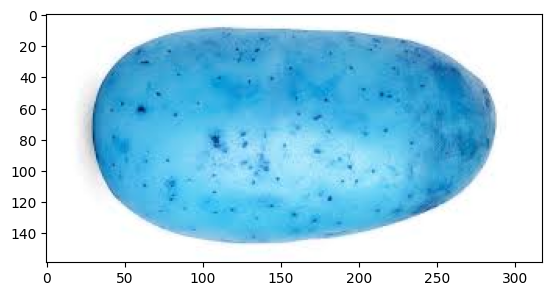

In [58]:
import cv2
import matplotlib.pyplot as plt

test_image=cv2.imread('/content/potato.jpeg')
plt.imshow(test_image)

In [59]:
# shape of the image
test_image.shape

(159, 318, 3)

In [60]:
import numpy as np
# Convert the image from BGR (OpenCV default) to RGB
test_image_rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

# Resize the image to the required input size of the model
test_image_resized = cv2.resize(test_image_rgb, (256, 256))

# Normalize the pixel values to the range [0, 1] since we are done batch normalisation
test_image_normalized = test_image_resized / 255.0

# Add a batch dimension
test_input = np.expand_dims(test_image_normalized, axis=0)

In [63]:
import numpy as np

# predict the output
predictions = model.predict(test_input)

# Get the index of the class with the highest predicted probability
predicted_class_indices = np.argmax(predictions, axis=1)

# Map the predicted class indices to class labels using the lookup table
predicted_class_labels = [lookup_table.lookup(tf.constant(class_names[index])) for index in predicted_class_indices]

# Print the predicted class labels
for i, label in enumerate(predicted_class_labels):
    print('Fruit' if label == 1 else 'Vegetable')



1/1 [==============================] - 0s 18ms/step
Vegetable


Note: Model predicted the class correctly.

# Transfer Learning

In [64]:
import tensorflow as tf

In [65]:
# download weights of pretrained model, MobileNetV2
conv_base=tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(256,256,3)
    )

9406464/9406464 [==============================] - 0s 0us/step


In [66]:
conv_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 128, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 128, 128, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 128, 128, 32)         0         ['bn_Conv1[

In [67]:
# create CNN architecture
model=Sequential()
# add conv_base
model.add(conv_base)
# convert 2D into 1D
model.add(Flatten())
# Add DEnse layers
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
# define output layer
model.add(Dense(1,activation='sigmoid'))

In [68]:
# set conv_base trainable to false, to avoid the training of conv_base paramters
conv_base.trainable=False

In [69]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_4 (Flatten)         (None, 81920)             0         
                                                                 
 dense_11 (Dense)            (None, 128)               10485888  
                                                                 
 dense_12 (Dense)            (None, 128)               16512     
                                                                 
 dense_13 (Dense)            (None, 1)                 129       
                                                                 
Total params: 12760513 (48.68 MB)
Trainable params: 10502529 (40.06 MB)
Non-trainable params: 2257984 (8.61 MB)
________

Note: There are 10502529  trainable parameters.

In [70]:
# function to normalise the pixel values of the image
def normalize(image,label):
  image = tf.cast(image/255,tf.float32)
  return image,label

In [71]:
# function to normalise the pixel values of the image
def normalize(image,label):
  image = tf.cast(image/255,tf.float32)
  return image,label

In [72]:
# compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [74]:
history=model.fit(train_ds,epochs=5,validation_data=validation_ds) # train the model

Epoch 1/5
98/98 [==============================] - 68s 653ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/5
98/98 [==============================] - 69s 648ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/5
98/98 [==============================] - 68s 652ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/5
98/98 [==============================] - 69s 644ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/5
98/98 [==============================] - 68s 650ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


In [75]:
test_image=cv2.imread('/content/potato.jpeg')

# Convert the image from BGR (OpenCV default) to RGB
test_image_rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

# Resize the image to the required input size of the model
test_image_resized = cv2.resize(test_image_rgb, (256, 256))

# Normalize the pixel values to the range [0, 1] since we are done batch normalisation
test_image_normalized = test_image_resized / 255.0

# Add a batch dimension
test_input = np.expand_dims(test_image_normalized, axis=0)

predictions = model.predict(test_input)

# Get the index of the class with the highest predicted probability
predicted_class_indices = np.argmax(predictions, axis=1)

# Map the predicted class indices to class labels using the lookup table
predicted_class_labels = [lookup_table.lookup(tf.constant(class_names[index])) for index in predicted_class_indices]

# Print the predicted class labels
for i, label in enumerate(predicted_class_labels):
    print('Fruit' if label == 1 else 'Vegetable')


1/1 [==============================] - 3s 3s/step
Vegetable


Note: Model predicted the class correctly.